# Fix Brainmasks

In [1]:
from pathlib import Path
import numpy as np
from nilearn import image
from nilearn import masking
from nilearn import plotting
import nibabel as nib
import matplotlib as plt
from tqdm.auto import tqdm, trange

In [2]:
dataset_v1 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000')
dataset_v2 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')

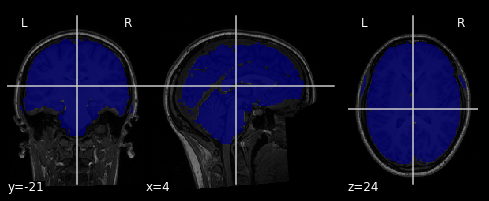

In [3]:
csi3_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI3_Structural/T1w_MPRAGE_CSI3.nii')
csi3_brainmask = image.load_img(str(dataset_v2 / 'CSI3_brainmask.nii.gz'))
plotting.plot_roi(csi3_brainmask, csi3_anat)

In [4]:
csi3_img = image.load_img(str(dataset_v2 / f'CSI3_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR-ZSCORE-ALL.nii.gz'))

In [5]:
csi3_data = csi3_img.get_fdata()

In [6]:
csi3_data.shape

(72, 88, 67, 5254)

In [7]:
np.count_nonzero(~np.isnan(csi3_data[...,0]))

186938

In [8]:
brainmask_data = csi3_brainmask.get_fdata()

In [9]:
brainmask_data.shape

(72, 88, 67)

In [10]:
np.count_nonzero(brainmask_data)

164058

In [11]:
newmask = csi3_data[...,0].copy()
newmask[~np.isnan(newmask)] = 1

In [12]:
newmask.shape

(72, 88, 67)

In [13]:
newmask[np.isnan(newmask)] = 0

In [14]:
newmask_img = image.new_img_like(csi3_brainmask, newmask)

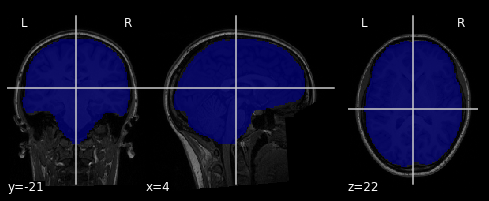

In [15]:
plotting.plot_roi(newmask_img, csi3_anat)

In [16]:
atlas = newmask * 2 + brainmask_data

In [17]:
np.unique(atlas)

array([0., 1., 2., 3.])

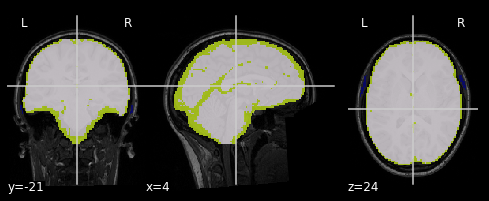

In [18]:
plotting.plot_roi(image.new_img_like(csi3_brainmask, atlas), csi3_anat)

In [19]:
csi3_data_masked = csi3_data[newmask != 0]

In [20]:
csi3_data_masked.shape

(186938, 5254)

In [21]:
np.count_nonzero(newmask)

186938

In [22]:
np.count_nonzero(np.isnan(csi3_data_masked))

6708211

In [23]:
csi3_data_masked[...,0].shape

(186938,)

In [24]:
np.count_nonzero(np.isnan(csi3_data_masked[...,5253]))

1087

In [25]:
lastmask = csi3_data[...,5253].copy()
lastmask[~np.isnan(lastmask)] = 1
lastmask[np.isnan(lastmask)] = 0

In [31]:
fvl = lastmask + newmask

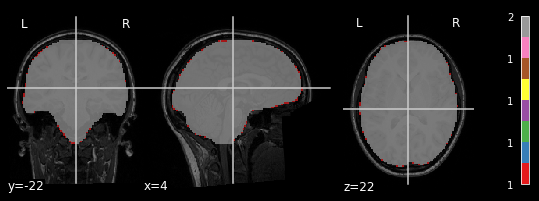

In [40]:
plotting.plot_roi(image.new_img_like(csi3_brainmask, fvl), csi3_anat, colorbar=True, cmap=plt.colormaps['Set1'])

In [39]:
np.unique(fvl)

array([0., 1., 2.])

In [41]:
# Create minimal brainmask

In [44]:
minmask = csi3_data[...,0].copy()
minmask[~np.isnan(minmask)] = 1
minmask[np.isnan(minmask)] = 0

In [4]:
def create_mask(img):
    mask = img.copy()
    mask[~np.isnan(mask)] = 1
    mask[np.isnan(mask)] = 0
    return mask

In [52]:
masks = np.apply_along_axis(create_mask, axis=3, arr=csi3_data)

In [50]:
m = create_mask(csi3_data[...,0])

In [51]:
m.shape

(72, 88, 67)

In [53]:
masks.shape

(72, 88, 67, 5254)

In [60]:
for i in range(masks.shape[-1]):
    minmask = np.logical_and(minmask, masks[...,i])

In [61]:
minmask.shape

(72, 88, 67)

In [70]:
np.count_nonzero(minmask)

182988

In [71]:
np.count_nonzero(newmask)

186938

In [66]:
np.count_nonzero(masks[...,-1] == 0)

237445

In [69]:
np.count_nonzero(np.isnan(csi3_data[...,-1]))

237445

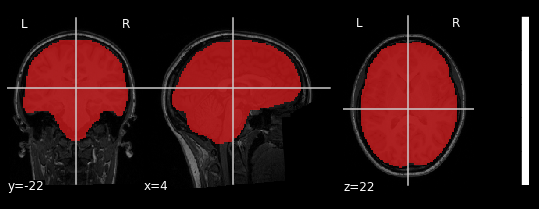

In [72]:
plotting.plot_roi(image.new_img_like(csi3_brainmask, minmask), csi3_anat, colorbar=True, cmap=plt.colormaps['Set1'])

In [73]:
csi3_data_masked = csi3_data[minmask != 0]

In [74]:
np.count_nonzero(np.isnan(csi3_data_masked))

0

## Generate New Brainmask for Each Participant

In [5]:
for participant in tqdm(range(1,5), desc='Participant'):
    data = nib.load(dataset_v2 / f'CSI{participant}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR-ZSCORE-ALL.nii.gz').get_fdata()
    minmask = create_mask(data[...,0])
    for i in trange(1, data.shape[-1]):
        minmask = np.logical_and(minmask, create_mask(data[...,i]))
        
    assert np.count_nonzero(np.isnan(data[minmask != 0])) == 0
    
    old_img = image.load_img(str(dataset_v2 / f'CSI{participant}_brainmask.nii.gz'))
    new_img = image.new_img_like(old_img, minmask)
    new_img.to_filename(dataset_v2 / f'CSI{participant}_mask-BRAIN.nii.gz')

Participant:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5253 [00:00<?, ?it/s]

  0%|          | 0/5253 [00:00<?, ?it/s]

  0%|          | 0/5253 [00:00<?, ?it/s]

  0%|          | 0/3107 [00:00<?, ?it/s]